In [2]:
import torch
import torch.nn as nn

import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import copy

In [23]:
# 设置图像读取器的超参数
image_size = 28  #图像的总尺寸28*28
num_classes = 10  #标签的种类数
num_epochs = 20  #训练的总循环周期
batch_size = 64  #批处理的尺寸大小

# 如果系统中存在着GPU，我们将用GPU来完成张量的计算
use_cuda = torch.cuda.is_available() #定义一个布尔型变量，标志当前的GPU是否可用

# 如果当前GPU可用，则将优先在GPU上进行张量计算
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor

# 加载MINIST数据，如果没有下载过，就会在当前路径下新建/data子目录，并把文件存放其中
# MNIST数据是属于torchvision包自带的数据，所以可以直接调用。
# 在调用自己的数据的时候，我们可以用torchvision.datasets.ImageFolder或者torch.utils.data.TensorDataset来加载
train_dataset = dsets.MNIST(root='./06_transfer_adder_data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor
                            download=True)

# 加载测试数据集
test_dataset = dsets.MNIST(root='./06_transfer_adder_data', 
                           train=False, 
                           transform=transforms.ToTensor())

# 定义两个采样器，每一个采样器都随机地从原始的数据集中抽样数据。抽样数据采用permutation
# 生成任意一个下标重排，从而利用下标来提取dataset中的数据
sample_size = len(train_dataset)
sampler1 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.choice(range(sample_size), sample_size))
sampler2 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.choice(range(sample_size), sample_size))

# 定义两个加载器，分别封装了前两个采样器，实现采样。
train_loader1 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           sampler = sampler1
                                           )
train_loader2 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           sampler = sampler2
                                           )

# 对于校验数据和测试数据，我们进行类似的处理。
val_size = 5000

val_indices1 = range(val_size)
val_indices2 = np.random.permutation(range(val_size))

test_indices1 = range(val_size, len(test_dataset)) # 从5000开始
test_indices2 = np.random.permutation(test_indices1)

val_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(val_indices1)
val_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(val_indices2)

test_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(test_indices1)
test_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(test_indices2)

val_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler1
                                        )
val_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler2
                                        )
test_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler1
                                         )
test_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler2
                                         )

# 为了比较不同数据量对迁移学习的影响，我们设定了一个加载数据的比例fraction
# 即我们只加载原训练数据集的1/fraction来训练网络
fraction = 1

In [25]:
depth = [4, 8]
class Transfer(nn.Module):
    def __init__(self):
        super(Transfer, self).__init__()
        # 两个并行的卷积通道，第一个通道：
        self.net1_conv1 = nn.Conv2d(1, 4, 5, padding = 2) #一个输入通道，4个输出通道（4个卷积核），窗口为5，填充2
        self.net_pool = nn.MaxPool2d(2, 2) #2*2 池化
        self.net1_conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2) #输入通道4，输出通道8（8个卷积核），窗口5，填充2
        
        # 第二个通道，注意pooling操作不需要重复定义
        self.net2_conv1 = nn.Conv2d(1, 4, 5, padding = 2) #一个输入通道，4个输出通道（4个卷积核），窗口为5，填充2
        self.net2_conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2) #输入通道4，输出通道8（8个卷积核），窗口5，填充2
        
        # 全链接层
        self.fc1 = nn.Linear(2 * image_size // 4 * image_size // 4 * depth[1] , 1024) #输入为处理后的特征图压平，输出1024个单元
        self.fc2 = nn.Linear(1024, 2 * num_classes) #输入1024个单元，输出20个单元
        self.fc3 = nn.Linear(2 * num_classes, num_classes) #输入20个单元，输出10个单元
        self.fc4 = nn.Linear(num_classes, 1) #输入10个单元，输出为1

    def forward(self, x, y, training = True):
        # 网络的前馈过程。输入两张手写图像x和y，输出一个数字表示两个数字的和
        # x,y都是batch_size*image_size*image_size形状的三阶张量
        # 输出为batch_size长的列向量
        
        # 首先，第一张图像进入第一个通道
        x = F.relu(self.net1_conv1(x)) #第一层卷积
        x = self.net_pool(x)   # 第一层池化
        x = F.relu(self.net1_conv2(x))  # 第二层卷积
        x = self.net_pool(x) # 第二层池化
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1]) # 将特征图张量压平
        
        
        y = F.relu(self.net2_conv1(y)) #第一层卷积
        y = self.net_pool(y) # 第一层池化
        y = F.relu(self.net2_conv2(y)) #第二层卷积
        y = self.net_pool(y) #第二层池化
        y = y.view(-1, image_size // 4 * image_size // 4 * depth[1])# 将特征图张量压平
        
        # 将两个卷积过来的铺平向量拼接在一起，形成一个大向量
        z = torch.cat((x, y), 1) #cat函数为拼接向量操作，1表示拼接的维度为第1个维度（0维度对应了batch）
        z = self.fc1(z) #第一层全链接
        z = F.relu(z)  #对于深层网络来说，激活函数用relu效果会比较好
        z = F.dropout(z, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        z = self.fc2(z) #第二层全链接
        z = F.relu(z)
        z = self.fc3(z) #第三层全链接
        z = F.relu(z)
        z = self.fc4(z) # 第四层全链接
        return z
    def set_filter_values(self, net):
        # 本函数为迁移网络所用，即将迁移过来的网络的权重值拷贝到本网络中
        # 本函数对应的迁移为预训练式
        # 输入参数net为从硬盘加载的网络作为迁移源
        
        # 逐个儿为网络的两个卷积模块的权重和偏置进行赋值
        # 注意在赋值的时候需要用deepcopy而不能直接等于，或者copy。
        # 这是因为这种拷贝是将张量中的数值全部拷贝到了目标中，而不是拷贝地址
        # 如果不用deepcopy，由于我们将同一组参数（net.conv1.weight.data,bias）
        #  赋予了两组参数（net1_conv1.weight.data，net2_conv1.weight.data）
        # 所以它们会共享源net.conv1.weight.data中的地址，这样对于net1_conv1.weight.data
        # 的训练也自然会被用到了net2_conv1.weight.data中，但其实我们希望它们是两个不同的参数。
        self.net1_conv1.weight.data = copy.deepcopy(net.conv1.weight.data)
        self.net1_conv1.bias.data = copy.deepcopy(net.conv1.bias.data)
        self.net1_conv2.weight.data = copy.deepcopy(net.conv2.weight.data)
        self.net1_conv2.bias.data = copy.deepcopy(net.conv2.bias.data)
        self.net2_conv1.weight.data = copy.deepcopy(net.conv1.weight.data)
        self.net2_conv1.bias.data = copy.deepcopy(net.conv1.bias.data)
        self.net2_conv2.weight.data = copy.deepcopy(net.conv2.weight.data)
        self.net2_conv2.bias.data = copy.deepcopy(net.conv2.bias.data)
        
        # 将变量加载到GPU上        
        self.net1_conv1 = self.net1_conv1.cuda() if use_cuda else self.net1_conv1
        self.net1_conv2 = self.net1_conv2.cuda() if use_cuda else self.net1_conv2
        
        self.net2_conv1 = self.net2_conv1.cuda() if use_cuda else self.net2_conv1
        self.net2_conv2 = self.net2_conv2.cuda() if use_cuda else self.net2_conv2
    def set_filter_values_nograd(self, net):
        # 本函数为迁移网络所用，即将迁移过来的网络的权重值拷贝到本网络中
        # 本函数对应的迁移为固定权重式
        # 调用set_filter_values为全部卷积核进行赋值
        self.set_filter_values(net)
        
        # 为了让我们的网络不被训练调整权值，我们需要设定每一个变量的requires_grad为False
        # 即不需要计算梯度值
        self.net1_conv1.weight.requires_grad = False
        self.net1_conv1.bias.requires_grad = False
        self.net1_conv2.weight.requires_grad = False
        self.net1_conv2.bias.requires_grad = False
        
        
        self.net2_conv1.weight.requires_grad = False
        self.net2_conv1.bias.requires_grad = False
        self.net2_conv2.weight.requires_grad = False
        self.net2_conv2.bias.requires_grad = False

def rightness(y, target):
    # 计算分类准确度的函数，y为模型预测的标签，target为数据的标签
    # 输入的y为一个矩阵，行对应了batch中的不同数据记录，列对应了不同的分类选择，数值对应了概率
    # 函数输出分别为预测与数据标签相等的个数，本次判断的所有数据个数
    out = torch.round(y.squeeze()).type(itype)
    out = out.eq(target).sum()
    out1 = y.size()[0]
    return(out, out1)

In [4]:
# 定义待迁移的网络框架，所有的神经网络模块包括：Conv2d、MaxPool2d，Linear等模块都不需要重新定义，会自动加载
# 但是网络的forward功能没有办法自动实现，需要重写。
# 一般的，加载网络只加载网络的属性，不加载方法
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # 将立体的Tensor全部转换成一维的Tensor。两次pooling操作，所以图像维度减少了1/4
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        
        x = F.relu(self.fc1(x)) #全链接，激活函数
        x = F.dropout(x, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        x = self.fc2(x) #全链接，激活函数
        x = F.log_softmax(x, dim =1) #log_softmax可以理解为概率对数值
        return x

In [6]:
original_net = torch.load('05_convolution_data/minst_conv_checkpoint', weights_only=False) #读取硬盘上的minst_conv_checkpoint文件

## 实验比较

分别进行三种实验，不迁移已训练好的网络， 使用预训练模式迁移，使用固定值模式迁移。 使用results分别保存三种模式的准确率做比较。

In [58]:
results = {}

### 1. 无迁移实验

在本试验中，我们不迁移网络，直接使用Transfer训练整个网络

In [59]:
# 生成网络实例
net = Transfer()

# 如果存在GPU，则将网络加载到GPU中
if use_cuda:
    net = net.cuda()
    
# 定义损失函数，我们用最小均方误差来定义损失
criterion = nn.MSELoss()

# 定义优化器
optimizer = optim.SGD(net.parameters(), lr = 0.0001, momentum = 0.9)

In [ ]:
# 开始训练网络
num_epochs = 20
records = []
for epoch in range(num_epochs):
    losses = []

    # 按批迭代
    # 我们可以用zip命令来同时从两个数据加载器中加载数据，enumerate则给这个迭代附加上了计数
    for idx, data in enumerate(zip(train_loader1, train_loader2)):
        # 为了比较数据量大小对迁移学习的影响，我们只加载了部分数据，当数据加载个数idx大于
        # 全数据集的1/fraction的时候则不再加载后面的数据
        if idx >= (len(train_loader1) // fraction):
            break
        ((x1, y1), (x2, y2)) = data
        if use_cuda:
            x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
        optimizer.zero_grad()
        net.train()
        outputs = net(x1.clone().detach(), x2.clone().detach())
        # outputs的size为(batch_size,1),用squeeze降为(batch_size) -hq 20200727
        # 代码其他处同样处理
        outputs = outputs.squeeze()
        labels = y1 + y2
        loss = criterion(outputs, labels.type(torch.float))
        loss.backward()
        optimizer.step()
        
        loss = loss.cpu() if use_cuda else loss
        losses.append(loss.data.numpy())
        if idx % 100 == 0:
            # 在校验数据上计算计算准确率
            val_losses = []
            rights = []
            net.eval()
            for val_data in zip(val_loader1, val_loader2):
                ((x1, y1), (x2, y2)) = val_data
                if use_cuda:
                    x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
                outputs = net(x1.clone().detach(), x2.clone().detach())
                outputs = outputs.squeeze()
                labels = y1 + y2
                loss = criterion(outputs, labels.type(torch.float))
                loss = loss.cpu() if use_cuda else loss
                val_losses.append(loss.data.numpy())
                right = rightness(outputs.data, labels)
                rights.append(right)
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第 {} 周期，第 ({}/{}) 批次，训练误差：{}, 校验误差：{:.2f}, 准确率：{:.2f}'.format(
                epoch, idx, len(train_loader1),
                np.mean(losses), np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])

# 在测试数据集上测试准确度
rights = []
net.eval()
for test_data in zip(test_loader1, test_loader2):
    ((x1, y1), (x2, y2)) = test_data
    if use_cuda:
        x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
    outputs = net(x1.clone().detach(), x2.clone().detach())
    outputs = outputs.squeeze()
    labels = y1 + y2
    loss = criterion(outputs, labels.type(torch.float))
    right = rightness(outputs.data, labels)
    rights.append(right)
right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
results['notransfer'] = [records, right_ratio]  

### 2. 迁移网络，预训练

在本试验中，我们将手写数字识别的卷积神经网络权重迁移过来，作为新的加法机网络的预训练值（也就是初始值）

In [61]:
net = Transfer()

# 为新网络赋予权重数值，注意我们只将卷积部分的网络进行迁移，而没有迁移全链接层
net.set_filter_values(original_net)

if use_cuda:
    net = net.cuda()

criterion = nn.MSELoss()

# 将需要训练的参数加载到优化器中
new_parameters = []
for para in net.parameters():
    if para.requires_grad: #我们只将可以调整权重的变量加到了集合new_parameters
        new_parameters.append(para)
        
# 将new_parameters加载到了优化器中
optimizer = optim.SGD(new_parameters, lr=0.0001, momentum=0.9)


In [ ]:
# 开始训练网络
num_epochs = 20
records = []
for epoch in range(num_epochs):
    losses = []
    for idx, data in enumerate(zip(train_loader1, train_loader2)):
        if idx >= (len(train_loader1) // fraction):
            break
        ((x1, y1), (x2, y2)) = data
        if use_cuda:
            x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
        net.train()
        optimizer.zero_grad()
        outputs = net(x1.clone().detach().requires_grad_(True), x2.clone().detach().requires_grad_(True))
        outputs = outputs.squeeze()
        labels = y1 + y2
        loss = criterion(outputs,labels.type(torch.float))
        loss.backward()
        optimizer.step()
        loss = loss.cpu() if use_cuda else loss
        losses.append(loss.data.numpy())
        if idx % 100 == 0:
            val_losses = []
            rights = []
            net.eval()
            for val_data in zip(val_loader1, val_loader2):
                ((x1, y1), (x2, y2)) = val_data
                if use_cuda:
                    x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
                outputs = net(x1.clone().detach().requires_grad_(True), x2.clone().detach().requires_grad_(True))
                outputs = outputs.squeeze()
                labels = y1 + y2
                loss = criterion(outputs, labels.type(torch.float))
                loss = loss.cpu() if use_cuda else loss
                val_losses.append(loss.data.numpy())
                
                right = rightness(outputs.data, labels)
                rights.append(right)
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}周期，第({}/{})批次，训练误差：{:.2f}, 校验误差：{:.2f}, 准确率：{:.2f}'.format(
                epoch, idx, len(train_loader1),
                np.mean(losses), np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])
rights = []
net.eval()
for test_data in zip(test_loader1, test_loader2):
    ((x1, y1), (x2, y2)) = test_data
    if use_cuda:
        x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
    outputs = net(x1.clone().detach().requires_grad_(True), x2.clone().detach().requires_grad_(True))
    outputs = outputs.squeeze()
    labels = y1 + y2
    loss = criterion(outputs, labels.type(torch.float))
    right = rightness(outputs.data, labels)
    rights.append(right)
right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
results['transfer_pretrained'] = [records, right_ratio] 

0.5018

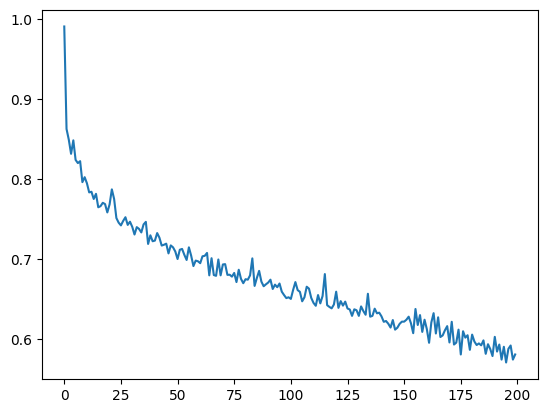

In [46]:
plt.plot([1 - i[2] for i in records])
right_ratio

### 3.迁移，不更新权重

在这个试验中，我们首先将识别器的卷积层的权重全部迁移到了加法机的两个卷积部件中，但保持它们的权重不变，只允许后面的全链接层的权重可训练。


In [67]:
net = Transfer()
# 迁移网络，并设置卷积部件的权重和偏置都不计算梯度
net.set_filter_values_nograd(original_net)
if use_cuda:
    net = net.cuda()
criterion = nn.MSELoss()

# 只将可更新的权重值加载到了优化器中
new_parameters = []
for para in net.parameters():
    if para.requires_grad:
        new_parameters.append(para)
optimizer = optim.SGD(new_parameters, lr=0.0001, momentum=0.9)

In [ ]:
# 训练整个网络
num_epochs = 20
records = []
for epoch in range(num_epochs):
    losses = []
    for idx, data in enumerate(zip(train_loader1, train_loader2)):
        if idx >= (len(train_loader1) // fraction):
            break
        ((x1, y1), (x2, y2)) = data
        if use_cuda:
            x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
        net.train()
        optimizer.zero_grad()
        outputs = net(x1.clone().detach().requires_grad_(True), x2.clone().detach().requires_grad_(True))
        outputs = outputs.squeeze()
        labels = y1 + y2
        labels = labels.type(dtype)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        loss = loss.cpu() if use_cuda else loss
        losses.append(loss.data.numpy())
        if idx % 100 == 0:
            val_losses = []
            rights = []
            net.eval()
            for val_data in zip(val_loader1, val_loader2):
                ((x1, y1), (x2, y2)) = val_data
                if use_cuda:
                    x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
                outputs = net(x1.clone().detach().requires_grad_(True), x2.clone().detach().requires_grad_(True))
                outputs = outputs.squeeze()
                labels = y1 + y2
                loss = criterion(outputs, labels.type(torch.float))
                loss = loss.cpu() if use_cuda else loss
                val_losses.append(loss.data.numpy())
                
                right = rightness(outputs.data, labels)
                rights.append(right)
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}周期，第({}/{})批次，训练误差：{:.2f}, 校验误差：{:.2f}, 准确率：{:.2f}'.format(
                epoch, idx, len(train_loader1),
                np.mean(losses), np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])
rights = []
net.eval()
for test_data in zip(test_loader1, test_loader2):
    ((x1, y1), (x2, y2)) = test_data
    if use_cuda:
        x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
    outputs = net(x1.clone().detach().requires_grad_(True), x2.clone().detach().requires_grad_(True))
    outputs = outputs.squeeze()
    labels = y1 + y2
    loss = criterion(outputs, labels.type(torch.float))
    right = rightness(outputs.data, labels)
    rights.append(right)
right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
results['transfer_fixed'] = [records, right_ratio]    

### 4、结果比较
将三次实验的结果放到一起比较

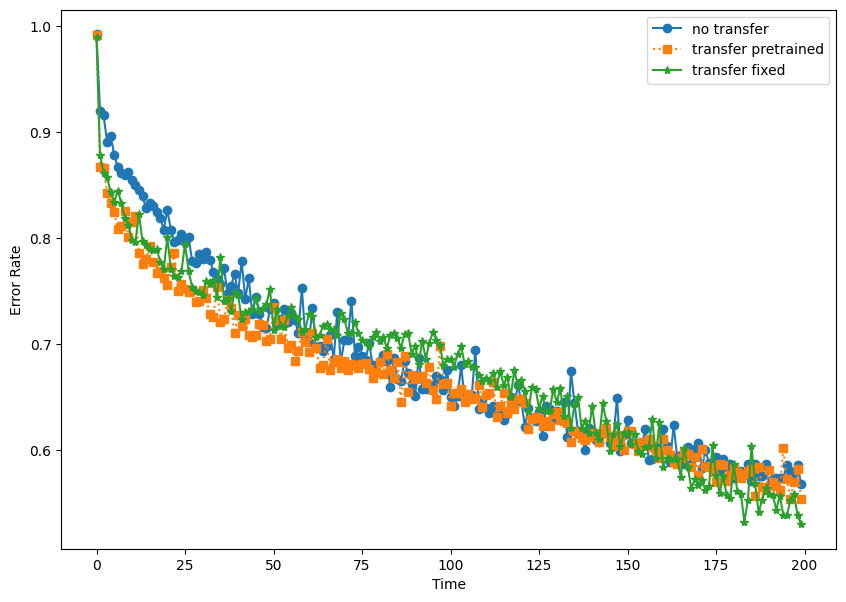

In [70]:
y1, y2, y3 = results['notransfer'][0], results['transfer_pretrained'][0], results['transfer_fixed'][0]
plt.figure(figsize = (10, 7))
plt.plot([1 - i[2] for i in y1], 'o-', label = 'no transfer')
plt.plot([1 - i[2] for i in y2], 's:', label = 'transfer pretrained')
plt.plot([1 - i[2] for i in y3], '*-', label = 'transfer fixed')
plt.xlabel('Time')
plt.ylabel('Error Rate')
plt.legend()